In [169]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import wandb
import os
from PIL import Image

os.environ["WANDB_SILENT"] = "true"
    

In [170]:
max_epochs = 10

In [171]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [172]:
dataset_path = "../Datasets/double_mnist_seed_123_image_size_64_64/"

In [173]:
train_dir_list = os.listdir(dataset_path + "train/")
train_dir_list = [x for x in train_dir_list if x[0] != x[1]]
train_dir_list.sort()
print(len(train_dir_list))

train_data_list = []
for i in range(len(train_dir_list)):
    img_list = os.listdir(dataset_path + "train/" + train_dir_list[i])
    for j in range(len(img_list)):
        train_data_list.append((dataset_path + "train/" + train_dir_list[i] + "/" + img_list[j], train_dir_list[i]))

print(len(train_data_list))

58
58000


In [174]:
val_dir_list = os.listdir(dataset_path + "val/")
val_dir_list = [x for x in val_dir_list if x[0] != x[1]]
val_dir_list.sort()
print(len(val_dir_list))

val_data_list = []
for i in range(len(val_dir_list)):
    img_list = os.listdir(dataset_path + "val/" + val_dir_list[i])
    for j in range(len(img_list)):
        val_data_list.append((dataset_path + "val/" + val_dir_list[i] + "/" + img_list[j], val_dir_list[i]))

print(len(val_data_list))

14
14000


In [175]:
test_dir_list = os.listdir(dataset_path + "test/")
test_dir_list = [x for x in test_dir_list if x[0] != x[1]]
test_dir_list.sort()
print(len(test_dir_list))

test_data_list = []
for i in range(len(test_dir_list)):
    img_list = os.listdir(dataset_path + "test/" + test_dir_list[i])
    for j in range(len(img_list)):
        test_data_list.append((dataset_path + "test/" + test_dir_list[i] + "/" + img_list[j], test_dir_list[i]))

print(len(test_data_list))

18
18000


In [176]:
test_data_list[0]

('../Datasets/double_mnist_seed_123_image_size_64_64/test/02/650_02.png', '02')

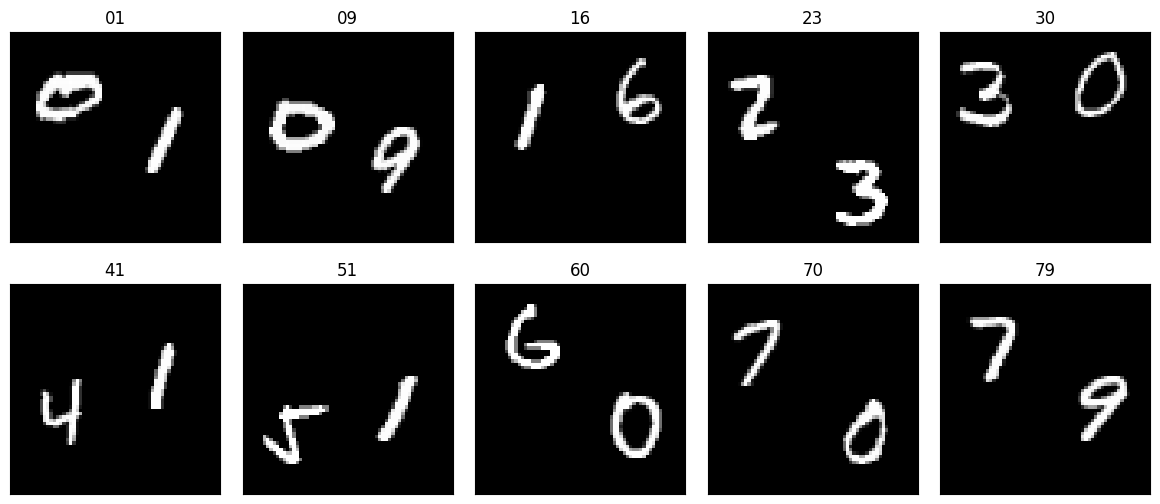

In [177]:
# Display some images from different classes of train set, picked randomly

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    img = plt.imread(train_data_list[i*5000][0])
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(train_data_list[i*5000][1])
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.show()

In [178]:
encoder = MultiLabelBinarizer(classes=[i for i in range(10)])
encoder.fit([[i] for i in range(10)])

MultiLabelBinarizer(classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [179]:
class MultiMNISTDataset(Data.Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        img = Image.open(img_path)
        img = np.array(img)
        if self.transform:
            img = self.transform(img)
        label = np.array([encoder.transform([[int(label[0])], ]).reshape(-1), encoder.transform([[int(label[1])], ]).reshape(-1)])
        label = label.reshape(-1).astype(np.float32)
        return img, label

In [180]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = MultiMNISTDataset(train_data_list, transform=transform)
val_dataset = MultiMNISTDataset(val_data_list, transform=transform)
test_dataset = MultiMNISTDataset(test_data_list, transform=transform)

train_loader = Data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = Data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = Data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

In [181]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPModel, self).__init__()
        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

In [182]:
input_size = 64*64
hidden_sizes = [512, 256, 128, 64]
output_size = 10*2

In [183]:
model = MLPModel(input_size, hidden_sizes, output_size)
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [184]:
def train_mlp(model, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.view(inputs.size(0), -1).to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

In [185]:
train_mlp(model, train_loader, max_epochs)

Epoch 1/10, Loss: 0.2957855207250714
Epoch 2/10, Loss: 0.2705284366194083
Epoch 3/10, Loss: 0.25601530658626714
Epoch 4/10, Loss: 0.24489681617502213
Epoch 5/10, Loss: 0.23222836848786044
Epoch 6/10, Loss: 0.2186197568731813
Epoch 7/10, Loss: 0.20605627539831173
Epoch 8/10, Loss: 0.19446745818153113
Epoch 9/10, Loss: 0.18448869595114065
Epoch 10/10, Loss: 0.17358545909270487


In [189]:
class CNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 20)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # 32 * 14 * 14
        x = self.pool(torch.relu(self.conv2(x))) # 64 * 7 * 7
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # x = self.softmax(x)
        return x

# Params using hyperparameter optimization

In [190]:
def train_cnn(model, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

In [191]:
cnn_model = CNN()
cnn_model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

train_cnn(cnn_model, train_loader, max_epochs)